In [1]:
import tensorflow as tf
from imageai.Detection import ObjectDetection
import os
import shutil
from kneed import KneeLocator
from keras.applications import ResNet50
from keras.models import Model
import cupy as cp
from sklearn.cluster import KMeans
import numpy as np

c:\Users\adam\AppData\Local\Programs\Python\Python310\lib\site-packages\cupy\_environment.py:440: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda112, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
raw_dir = 'data/rawmotorcycles'
output_dir = 'tmp'
batch_size = 32
image_size = (224, 224)

In [4]:
# Step 1: Load data and extract motorcycles and persons from images
def extract_objs_from_images(input_dir: str, output_dir: str) -> None:
    '''
    input_dir: Input directory containing folders with unprocessed input.
    output dir: Output dir where folders containing proccessed input will be placed.
    
    1. Loops through every folder in the input dir and every image within each folder.
    2. This method then identifies motorbike and person within each image.
    3. After identification, this method will crop the objects identified and save them in the output dir, respective to its containing folder.
    '''
    # Arrange
    execution_path = os.getcwd()
    detector = ObjectDetection()
    detector.setModelTypeAsYOLOv3()
    detector.setModelPath(os.path.join(execution_path , "models/yolov3.pt"))
    custom_objects = detector.CustomObjects(person=True, motorbike=True)
    detector.loadModel()
    
    
    # Act

    images = os.listdir(input_dir)
    for image in images:
        image_path = os.path.join(execution_path, '{0}/{1}'.format(input_dir, image))
        output_image_path = os.path.join(execution_path ,'{0}'.format(output_dir))
        output_image = f'{output_image_path}/{image}_detected.jpg'
        detections, extracted_objects  = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , image_path),
                                                                        extract_detected_objects=True,
                                                                        output_image_path=output_image,
                                                                        custom_objects=custom_objects,
                                                                        minimum_percentage_probability=80)
        os.remove(output_image)            
        for i, obj in enumerate(detections):
            print(obj)
            new_image_name = '{0}-{1}{2}'.format(image.replace('.jpg', ''), detections[i]['name'], '.jpg')
            new_path = '{0}/{1}'.format(output_image_path, new_image_name)
            shutil.copy(extracted_objects[i], new_path) 
        if extracted_objects:
            shutil.rmtree(os.path.dirname(extracted_objects[0]))
                    


In [5]:
def generate_raw_dataset(data_dir, validation_split=0.2):
    return tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size)

In [6]:
def extract_class_count(data_dir, min, max):
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    # Extract the feature extractor
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-1].output)


    # Load your images
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.0,
    seed=42,
    label_mode=None,
    image_size=(224, 224),
    batch_size=32)

    features_train = feature_extractor.predict(train_ds)

    features_train_flattened = np.reshape(features_train, (features_train.shape[0], -1))


    SSE = []

    # Loop over different numbers of clusters
    for cluster in range(min, max):
        print('iteration - {}'.format(str(cluster)))
        kmeans = KMeans(n_clusters=cluster, random_state=0).fit(features_train_flattened)
        SSE.append(kmeans.inertia_)
    
    sensitivity = [1, 3, 5, 10, 100, 200, 400]
    knees = []
    norm_knees = []


    x = range(min, len(SSE)+min)

    for s in sensitivity:
        k1 = KneeLocator(x, SSE, curve="convex", direction="increasing", S=s)
        knees.append(k1.knee)
        # kl = KneeLocator(x, SSE, curve="convex", direction="decreasing", S=s)
        # knees_dsc.append(kl.knee)
        norm_knees.append(k1.norm_knee)
        

        
    return knees, SSE

In [7]:
# extract_objs_from_images('data/rawmotorcycles', 'tmp')
min, max = 10, 50

knees, SSE = extract_class_count('./tmp', min, max)



Found 1909 files belonging to 1 classes.
60/60 [==============================] - 27s 72ms/step
iteration - 10


MemoryError: Unable to allocate 731. MiB for an array with shape (1909, 100352) and data type float32

[518323584.0, 513480000.0, 509372128.0, 505365632.0, 501122336.0, 497250048.0, 494257472.0, 490712032.0, 488852768.0, 485694752.0]
[14, 14, 14, 14, None, None, None]


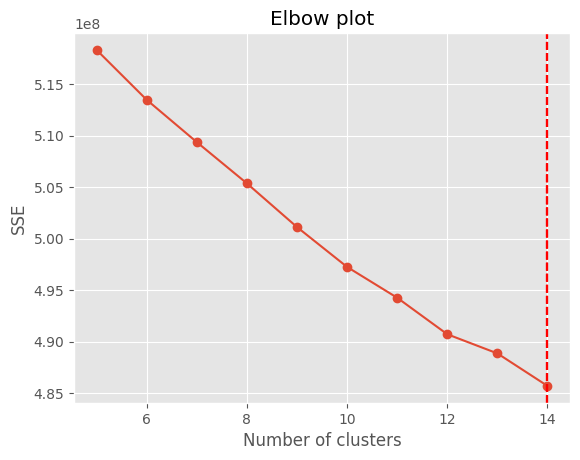

In [ ]:
print(SSE)
print(knees)
import matplotlib.pyplot as plt



plt.plot(range(min, len(SSE)+min), SSE, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow plot')

for knee in knees:
    if knee is not None:
        plt.axvline(x=knee, color='red', linestyle='--')

plt.show()

OS                           : Windows-10-10.0.22000-SP0
Python Version               : 3.10.5
CuPy Version                 : 10.6.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.24.1
SciPy Version                : 1.9.3
Cython Build Version         : 0.29.30
Cython Runtime Version       : 0.29.33
CUDA Root                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2
nvcc PATH                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin\nvcc.EXE
CUDA Build Version           : 11020
CUDA Driver Version          : 12000
CUDA Runtime Version         : 11020
cuBLAS Version               : (available)
cuFFT Version                : 10400
cuRAND Version               : 10203
cuSOLVER Version             : (11, 0, 2)
cuSPARSE Version             : (available)
NVRTC Version                : (11, 2)
Thrust Version               : 101000
CUB Build Version            : 101000
Jitify Build Version         : 4a37de0
cuDNN Build Ver

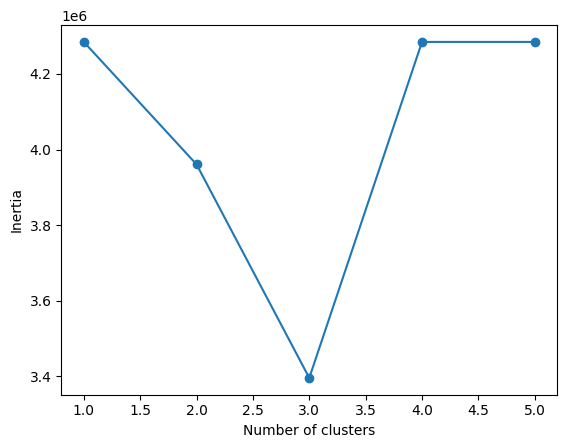

4

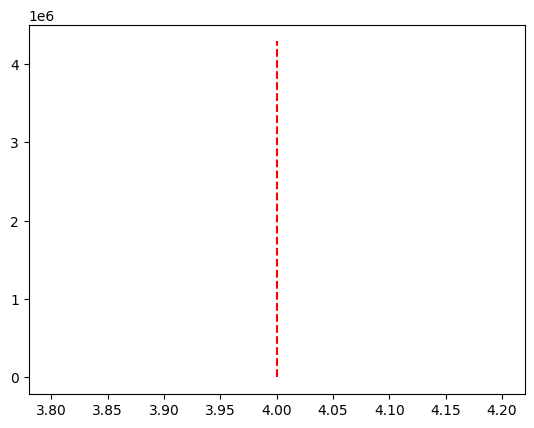

In [8]:
import cupy as cp
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

cp.show_config()

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
'./tmp2',
validation_split=0.0,
seed=42,
label_mode=None,
image_size=(224, 224),
batch_size=4)

model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))


feature_extractor = Model(inputs=model.input, outputs=model.layers[-1].output)


features_train = feature_extractor.predict(train_ds)

features_train_flattened = np.reshape(features_train, (features_train.shape[0], -1))

def kmeans(X, n_clusters, max_iter=300):
    # Initialize cluster centroids randomly
    N, D = X.shape
    centroids = cp.random.randn(n_clusters, D)

    for i in range(max_iter):
        # Compute distances between each data point and each centroid
        distances = cp.sum((X[:, cp.newaxis, :] - centroids) ** 2, axis=2)

        # Assign each data point to the closest centroid
        cluster_assignments = cp.argmin(distances, axis=1)

        # Recalculate the centroids
        for j in range(n_clusters):
            centroids[j] = cp.mean(X[cluster_assignments == j], axis=0)

    return centroids, cluster_assignments


# Fit k-means model to the data
features_train_flattened = cp.array(features_train_flattened)

import matplotlib.pyplot as plt

def calculate_elbow(features, max_clusters):
    inertias = []
    for k in range(1, max_clusters + 1):
        centroids, cluster_assignments = kmeans(features, n_clusters=k)
        inertia = cp.sum(cp.min(cp.sum((features[:, cp.newaxis, :] - centroids[cluster_assignments])**2, axis=2), axis=1))
        inertias.append(inertia.get())
        
    # Plot the inertia for each number of clusters
    plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

    # Find the "elbow" by selecting the number of clusters where the change in inertia begins to slow down
    delta_inertia = [inertias[i] - inertias[i-1] for i in range(1, len(inertias))]
    elbow = delta_inertia.index(max(delta_inertia)) + 2
    plt.vlines(x=elbow, ymin=0, ymax=inertias[elbow-1], colors='red', linestyles='dashed')
    
    return elbow

calculate_elbow(features_train_flattened, max_clusters=5)